In [1]:
import os
import h5py
import gvar   as gv
import numpy  as np
import pandas as pd
from   matplotlib import pyplot as plt

def RatioFileString(name,ts,h,hss,q,l,p):
    return f'{name}T{ts}{h}_RW_{hss}_rot_rot{q}{l}_p{p}'

def format(v):
    return gv.gvar(
        v.mean(axis=0),
        v.std(axis=0) * np.sqrt(v.shape[0]-1)
    )

def plot(v,**kwargs):
    plt.errorbar(
        np.arange(len(v)),
        gv.mean(v),
        gv.sdev(v),
        fmt='.',
        **kwargs
    )

def jkCorr(data, bsize=1):
    if bsize==0:
        return data
    else:
        rData = (data.shape[0]//bsize)
        nData = rData*bsize
        dIn   = data[0:nData,:]

        avg   = dIn.mean(axis=0)

        base  = dIn.sum(axis=0) # avg * nData

        dOut  = dIn * 0.0

        for cf in range(rData):
            pvg = dIn[cf*bsize:(cf+1)*bsize,:].sum(axis=0)
            dOut[cf,:] = (base - pvg)/(nData - bsize)

        return dOut[:rData,:]

In the following cell import `FnalHISQMetadata` module giving the correct path

In [2]:
from b2heavy.FnalHISQMetadata import params # change

ens = 'Coarse-1'
mom = '300'
jk  = 11

mdata = params(ens)
Ta,Tb = mdata['hSinks']

heavy = '_k' + mdata['kBStr']
light = '_k' + mdata['kDStr']
qq    = '_m' + mdata['mlStr']

data = h5py.File(f'/Users/pietro/code/data_analysis/BtoD/Alex/Ensembles/FnalHISQ/a0.12/{mdata["hdf5File2"]}')
data = data['data']

$$
 R_{A_1}(\mathbf{p}_\perp,t,T) = \frac{ C_{B_{1S}\rightarrow D^*_a}^{A_j}(\mathbf{p}_\perp,t,T) \,\, C_{D^*_a\rightarrow B_{1S}}^{A_j}(\mathbf{p}_\perp,t,T) }{  C_{D^*_a\rightarrow D^*_{1S}}^{V_4}(\mathbf{0},t,T) \,\,   C_{B_{1S}\rightarrow B_{1S}}^{V_4}(\mathbf{0},t,T) } / \Biggl[\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbb p)} e^{-({E_{D^*}}(\mathbb p) - M_{D^*})T}\Biggr]
$$ 

## Reading

in the following cells we read the data from the archive and we build the uncorrected ratio for each smearing and each sink time and we put it in a dictionary `data_read`

------------- tsink = 12 --------- smr = '1S' -------------------
P5_A2_V2_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
V1_V4_V1_T12_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = '1S' -------------------
P5_A2_V2_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.12201_p300
V1_V4_V1_T13_k0.12201_RW_1S_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 12 --------- smr = 'RW' -------------------
P5_A2_V2_T12_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
V1_V4_V1_T12_k0.12201_RW_RW_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T12_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000
------------- tsink = 13 --------- smr = 'RW' -------------------
P5_A2_V2_T13_k0.08574_RW_RW_rot_rot_m0.00507_k0.12201_p300
V1_V4_V1_T13_k0.12201_RW_RW_rot_rot_m0.00507_k0.12201_p000
P5_V4_P5_T13_k0.08574_RW_1S_rot_rot_m0.00507_k0.08574_p000


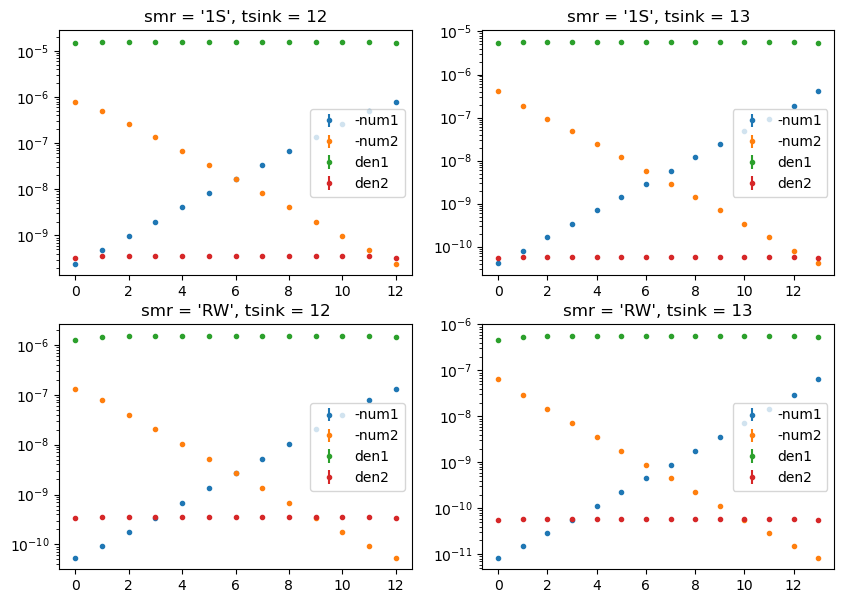

In [3]:
fig,ax = plt.subplots(2,2,figsize=(10,7))

data_read = {}
for i,smr in enumerate(['1S','RW']):
    data_read[smr] = {}
    for j,tsink in enumerate([Ta,Tb]):
        print(f'------------- {tsink = } --------- {smr = } -------------------')

        # Numerator 1 ===========================================================
        corr = RatioFileString('P5_A2_V2_',tsink,heavy,smr,qq,light,mom)
        num1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Numerator 2 ===========================================================
        num2 = np.flip(num1,axis=-1)



        # Denominator 1 ===========================================================
        corr = RatioFileString('V1_V4_V1_',tsink,light,smr,qq,light,'000')
        den1 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        # Denominator 2 ===========================================================
        corr = RatioFileString('P5_V4_P5_',tsink,heavy,'1S',qq,heavy,'000')
        den2 = jkCorr(data[corr][:,:(tsink+1)], bsize=jk)
        print(corr)

        data_read[smr][tsink] = num1 * num2 / den1 / den2





        v = -format(num1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='-num1',color='C0')
        v = -format(num2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='-num2',color='C1')
        v = format(den1)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den1',color='C2')
        v = format(den2)
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='den2',color='C3')

        ax[i,j].set_title(f'{smr = }, {tsink = }')
        ax[i,j].set_yscale('log')
        ax[i,j].legend()

-------------- tsink = 12 smr = '1S' --------------
[0.0394(58) 0.0431(48) 0.0462(48) 0.0483(47) 0.0486(47) 0.0489(50)
 0.0485(50) 0.0489(50) 0.0485(47) 0.0482(47) 0.0461(48) 0.0430(48)
 0.0388(57)]
13
-------------- tsink = 13 smr = '1S' --------------
[0.0555(66) 0.0445(58) 0.0450(56) 0.0483(58) 0.0490(59) 0.0503(61)
 0.0500(64) 0.0501(64) 0.0507(61) 0.0490(58) 0.0483(58) 0.0451(56)
 0.0446(58) 0.0560(67)]
14
-------------- tsink = 12 smr = 'RW' --------------
[0.0170(15) 0.0136(10) 0.01331(90) 0.01294(79) 0.01250(75) 0.01271(77)
 0.01303(80) 0.01273(77) 0.01243(75) 0.01294(78) 0.01318(88) 0.01314(97)
 0.0149(13)]
13
-------------- tsink = 13 smr = 'RW' --------------
[0.0215(21) 0.0141(14) 0.0131(13) 0.0128(12) 0.0123(13) 0.0124(13)
 0.0122(13) 0.0122(13) 0.0125(12) 0.0124(13) 0.0127(13) 0.0130(13)
 0.0137(14) 0.0188(19)]
14


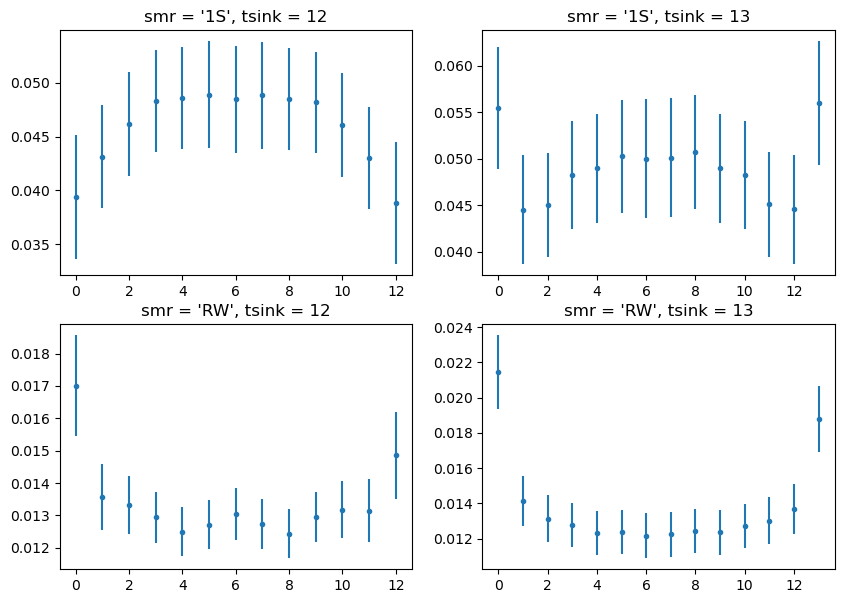

In [4]:
fig,ax = plt.subplots(2,2,figsize=(10,7))
for i,smr in enumerate(data_read):
    for j,tsink in enumerate(data_read[smr]):
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_read[smr][tsink]))
        print(len(format(data_read[smr][tsink])))

        v = format(data_read[smr][tsink])
        ax[i,j].errorbar(np.arange(len(v)),gv.mean(v),gv.sdev(v),fmt='.',label='num1',color='C0')
        ax[i,j].set_title(f'{smr = }, {tsink = }')

## Build correction factor

In the following cell we build the correction factor
$$\frac{Z_{D^*_a}(\mathbf p_\perp)}{\sqrt{Z_{D^*_a}(0)Z_{D_{1S}^*}(0)}} \frac{{M_{D^*}}^2}{{E^2_{D^*}}(\mathbf p)}$$

In [5]:
# This cell has only to be evaluated if next python cell is not

from b2heavy.ThreePointFunctions.types3pts import ratio_prerequisites

# frm = '/Users/pietro/code/data_analysis/data/QCDNf2p1stag/B2heavy/lattice24_old'
frm = '/Users/pietro/Desktop/lattice24/0.25/corr2_3'
req = ratio_prerequisites(ens,'RA1',mom,readfrom=frm)
req

{'E0': 1.179682175085136,
 'm0': 1.0809632444217314,
 'Z0': {'1S': 4.822281482026914, 'd': 0.04150728444106053},
 'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
 'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
 'Zp': {'1S': None, 'd': None},
 'wrecoil': 1.1126285207974154,
 'jk': False}

Fill the following cells with appropriate values

In [6]:
# req = {
#     'E0': 1.179682175085136,
#     'm0': 1.0809632444217314,
#     'Z0':   {'1S': 4.822281482026914, 'd': 0.04150728444106053},
#     'Zpar': {'1S': 1.6320372022086296, 'd': 0.033818481030701474},
#     'Zbot': {'1S': 1.1536983427438878, 'd': 0.02595700174869827},
# }

In [7]:
factor = {
    '1S': req['Zbot']['1S']/np.sqrt( req['Z0']['1S'] * req['Z0']['1S'] ) * (req['m0']/req['E0'])**2,#req['wrecoil']**2, #,
    'RW': req['Zbot']['d' ]/np.sqrt( req['Z0']['d' ] * req['Z0']['1S'] ) * (req['m0']/req['E0'])**2,#req['wrecoil']**2, #,
}

factor

{'1S': 0.20087760937269686, 'RW': 0.04871446157124346}

here we divide the data that we read by the correction factor

In [8]:
data_corr = {smr: {} for smr in data_read}

for smr in data_read:
    for tsink in data_read[smr]:
        data_corr[smr][tsink] = data_read[smr][tsink][:,:Ta+1] / factor[smr]
        print(f'-------------- {tsink = } {smr = } --------------')
        print(format(data_corr[smr][tsink]))

-------------- tsink = 12 smr = '1S' --------------
[0.196(29) 0.215(24) 0.230(24) 0.241(23) 0.242(24) 0.243(25) 0.241(25)
 0.243(25) 0.242(24) 0.240(23) 0.230(24) 0.214(24) 0.193(28)]
-------------- tsink = 13 smr = '1S' --------------
[0.276(33) 0.222(29) 0.224(28) 0.240(29) 0.244(29) 0.250(30) 0.249(32)
 0.249(32) 0.253(31) 0.244(29) 0.240(29) 0.225(28) 0.222(29)]
-------------- tsink = 12 smr = 'RW' --------------
[0.349(32) 0.278(21) 0.273(18) 0.266(16) 0.257(15) 0.261(16) 0.268(16)
 0.261(16) 0.255(15) 0.266(16) 0.270(18) 0.270(20) 0.305(28)]
-------------- tsink = 13 smr = 'RW' --------------
[0.440(43) 0.290(29) 0.270(27) 0.262(26) 0.253(26) 0.254(26) 0.250(26)
 0.251(26) 0.256(26) 0.254(26) 0.261(26) 0.267(27) 0.281(29)]


## Exponentials + smoothening

$$
\bar R_{A_1}(t,T) = \frac{1}{2}R_{A_1}(t,T) e^{(E-M)T} + \frac{1}{4}R_{A_1}(t,T+1) e^{(E-M)(T+1)} + \frac{1}{4}R_{A_1}(t+1,T+1) e^{(E-M)(T+1)}
$$

In [9]:
exp = np.exp((req['E0']-req['m0']))

barR = {}
barR['1S'] = data_corr['1S'][Ta  ]/2 * exp**Ta     +     data_corr['1S'][Tb]/4 * exp**Tb  +  np.roll(data_corr['1S'][Tb],-1,axis=1)/4 * exp**Tb
barR['RW'] = data_corr['RW'][Ta  ]/2 * exp**Ta     +     data_corr['RW'][Tb]/4 * exp**Tb  +  np.roll(data_corr['RW'][Tb],-1,axis=1)/4 * exp**Tb

In [10]:
for sm in ['1S','RW']:
    print(f'------------ {sm = } -------------')
    print(format(barR[sm]))

------------ sm = '1S' -------------
[0.770(78) 0.753(70) 0.795(71) 0.830(71) 0.841(72) 0.848(76) 0.844(77)
 0.851(76) 0.843(72) 0.829(71) 0.795(71) 0.753(70) 0.766(78)]
------------ sm = 'RW' -------------
[1.230(88) 0.960(63) 0.926(57) 0.899(52) 0.877(50) 0.882(51) 0.889(52)
 0.884(51) 0.876(50) 0.899(52) 0.919(57) 0.936(62) 1.149(83)]


<ErrorbarContainer object of 3 artists>

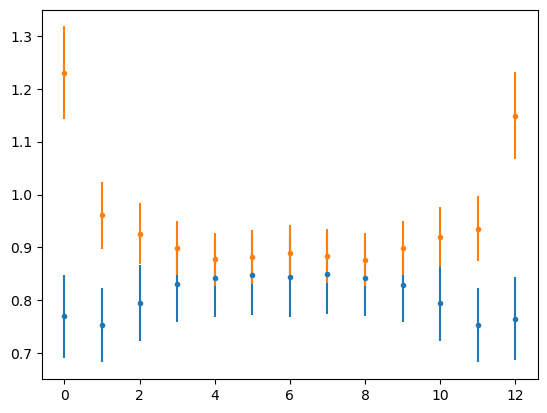

In [11]:
y1S = format(barR['1S'])
yRW = format(barR['RW'])
x   = np.arange(len(y1S))

plt.errorbar(x,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.errorbar(x,gv.mean(yRW),gv.sdev(yRW),fmt='.')

# `CUSTOM`

In [12]:
from b2heavy.ThreePointFunctions.types3pts  import Ratio, RatioIO, ratio_prerequisites
from b2heavy.ThreePointFunctions.fitter3pts import RatioFitter, phys_energy_priors
from b2heavy.ThreePointFunctions.utils      import read_config_fit, dump_fit_object
from b2heavy.ThreePointFunctions.corr3pts   import BINSIZE

In [13]:
DATA_DIR = '/Users/pietro/code/data_analysis/BtoD/Alex/'
io = RatioIO(ens,'RA1',mom,PathToDataDir=DATA_DIR)
robj = RatioFitter(
    io,
    jkBin     = BINSIZE[ens],
    smearing  = ['1S','RW'],
    **req
)

In [14]:
x,rr = robj.format()
r1S = rr['1S']
rRW = rr['RW']

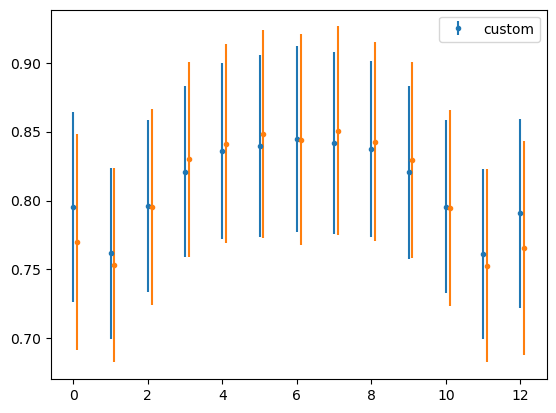

In [15]:
plt.errorbar(x,gv.mean(r1S),gv.sdev(r1S),fmt='.',label='custom')
plt.errorbar(x+0.1,gv.mean(y1S),gv.sdev(y1S),fmt='.')
plt.legend()

<ErrorbarContainer object of 3 artists>

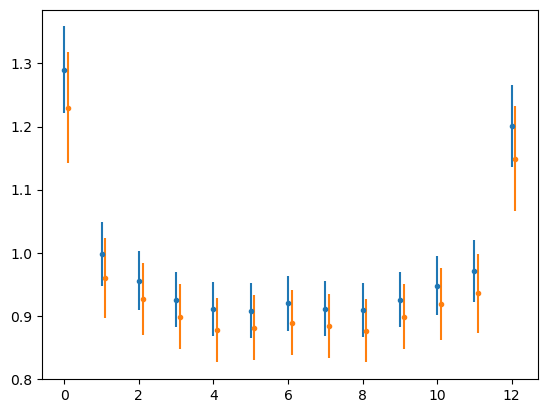

In [16]:
plt.errorbar(x    ,gv.mean(rRW),gv.sdev(rRW),fmt='.')
plt.errorbar(x+0.1,gv.mean(yRW),gv.sdev(yRW),fmt='.')